# Homework 1 Part 5

## Course Name: Large Language Models
#### Lecturers: Dr. Soleimani, Dr. Rohban, Dr. Asgari

---

#### Notebooks Supervised By: MohammadAli SadraeiJavaheri
#### Notebooks Prepared By: Zeinab Sadat Taghavi, Hamed Jamshidian, Seyed Mohammad Reza Modarres

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---

**Note**: Replace the placeholders (between `## Your code begins ##` and `## Your code ends ##`) with the appropriate details.


# Introduction

### What is LoRA?

Low-rank adaptation, or LoRA, is a finetuning method that was developed by [Hu et al. in 2021](https://https://arxiv.org/abs/2106.09685). It is based on the idea that most models are overparameterized. If most models are overparameterized, then modifying all of the model's parameters during finetuning is a waste of compute. We should be able to modify a small subset of parameters and still be able to achieve improved performance on the targeted objective. This is the key idea behind LoRa.

This process involves injecting the matrices into the dense layer's update, optimizing them for the specific adaptation task while the original pretrained model weights remain unchanged.

Here are some of the key points of the LoRA technique:

* **Freezing Pretrained Weights**: Instead of modifying all the parameters of a pretrained model during fine-tuning, LoRA freezes the pretrained weights. This means that the original model weights remain unchanged during the adaptation process.

* **Rank Decomposition Matrices**: LoRA freezes the pretrained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture. These matrices are used to adjust the output of each layer in a way that's specific to the adaptation task.

* **Indirect Training of Dense Layers**: The rank decomposition matrices allow for the indirect training of each dense layer in the neural network. They are injected into the layer's update during the adaptation process and optimized to enhance the layer's performance on the specific task or domain.

* **Significant Reduction in Trainable Parameters**: By focusing on these rank decomposition matrices instead of the entire set of model weights, LoRA greatly reduces the number of trainable parameters for downstream tasks. For instance, in the case of GPT-3, LoRA can reduce the number of trainable parameters by a factor of 10,000.

* **Maintaining Model Performance**: Despite the significant reduction in the number of trainable parameters, the LoRA technique is designed to maintain or even improve the performance of the large language model on the specific task or domain.

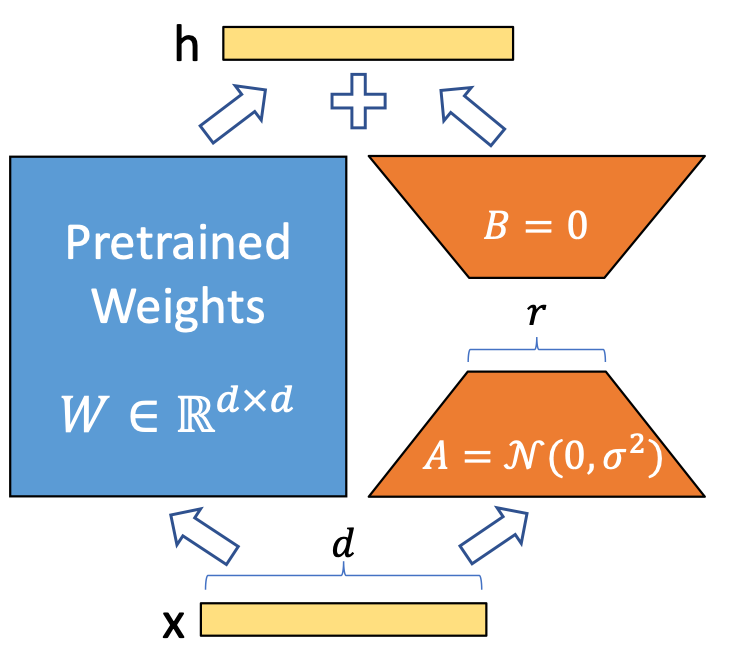


In a nutshell, in LoRA you freeze all the models weights and then inject low rank matrices A, B into any linear layer that you want. if the inititall linear layer has n\*m dimensions, A dimension must be n\*r and B r\* m so A@B will have n\*m dmentions and can be added with W (the pretained weight).

Now some details:

When doing regular fine-tuning, we update W and get x.W as the output of the module but here we freeze W and update A and B and the output of the module is h = x.W + x.A@B. since W  and A@B have the same dimentions, the addition is possible.

We also need to scale x.A@B by a scaling factor $α$.

According to the paper, A should be initialized with [Kaiming He initialization](https://medium.com/@shauryagoel/kaiming-he-initialization-a8d9ed0b5899
)
and B initialized to zeros.

Useful links:
* [https://arxiv.org/abs/2106.09685](https://)
* [https://huggingface.co/docs/peft/conceptual_guides/lora](https://)
* [https://sh-tsang.medium.com/brief-review-lora-low-rank-adaptation-of-large-language-models-faf5ddd5802f](https://)


### Requirements

In [1]:
%%capture
! pip install datasets transformers

### Imports

In [2]:
from tqdm.notebook import tqdm
from IPython import display

import numpy as np
import pandas as pd
import math

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

from datasets import load_dataset
from transformers import T5TokenizerFast, T5ForConditionalGeneration, DataCollatorForSeq2Seq

### Constants

We will use `t5-small` as our base model. We want to tune `10` soft prompt tokens.

In [3]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

BASE_MODEL_NAME = 't5-small'

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10
RANK = 8
ALPHA = 4.0

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

### Load dataset

`imdb` dataset is a famouns NLP sentiment dataset. Each row of data is either `negative` or `positive`.

In [4]:
dataset = load_dataset('imdb')
dataset.pop('unsupervised')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})


### Define related functions

Because `T5` model is a sequence to sequence model we should map our labels to label_names before training and doing vice versa duing calculating metrics.

The functions `id2label` and `label2id` are defined to do this.

In [5]:
def id2label(ids):
    label_names = ['negative', 'positive']
    return [label_names[id] for id in ids]

def label2id(labels):
    label_names_dict = {
        'negative': 0,
        'positive': 1
    }
    return [
        label_names_dict.get(label, 2)
        for label in labels
    ]

# Tokenizer

### Load tokenizer

In [6]:
tokenizer = T5TokenizerFast.from_pretrained(BASE_MODEL_NAME)

### Process dataset using tokenizer

In this step we will getting our dataset ready for training.

We preprocess tokenize our `text` and `label`.

In [7]:
def preprocess_input(text):
    text = text.lower()
    text = text.replace('<br />', ' ')
    return text

def map_function(row):
    processed_input = [
        preprocess_input(text)
        for text in row['text']
    ]
    input_info = tokenizer(processed_input, truncation=True, max_length=256)
    output_info = tokenizer(id2label(row['label']))
    return {
        **input_info,
        'labels': output_info.input_ids
    }


dataset = dataset.map(map_function, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Model

### Load model

In [8]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_NAME)

### Implementing LoRA

Here we implement LoraLayer, the module which we want to replace with Linear modules.

<font color='#73FF73'><b>You have to complete</b></font> `LoRALayer` <font color='#73FF73'><b>function.</b></font>

Replace `None` with your code.

Do not forget that linear layer in lora doesn't have `bias`.

You can use `nn.init.kaiming_uniform_` and `nn.init.zeros_` for initilization.

In [11]:
class LoRALayer(nn.Module):
    def __init__(
        self,
        module: nn.Linear,
        rank: int = RANK,
        alpha: float = ALPHA
        ):

        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = self.alpha / self.rank # scaling factor
        self.in_dim = module.in_features
        self.out_dim = module.out_features
        self.pretrained = module
        ######### Your code begins #########
        # create the A and initialize with Kaiming
        self.sharif_llm_A = nn.Linear(self.in_dim , self.rank , bias = False)
        # initilize sharif_llm_A
        nn.init.kaiming_uniform_(self.sharif_llm_A .weight)
        # create B and initialize with zeros
        self.sharif_llm_B = nn.Linear(self.rank , self.out_dim , bias = False)
        # initilize sharif_llm_B
        nn.init.zeros_(self.sharif_llm_B.weight)
        ######### Your code ends ###########


    def forward(self, x: torch.Tensor):

        pretrained_out = self.pretrained(x) # get the pretrained weights -> x.W

        # do the forward path for low rank matrices and scale the result
        ######### Your code begins #########
        lora_out = self.sharif_llm_A(x) # x@A
        lora_out = self.sharif_llm_B(lora_out) # x@A@B
        lora_out = self.scaling * lora_out # Scale by the scaling factor
        ######### Your code ends ###########

        return pretrained_out + lora_out # x@W + x@A@B*(scaling_factor)

### Change the model

Now we want to change the model and replace some modlues with LoRA modules. The following picture from the original paper shows what we can change and what rank should we use.
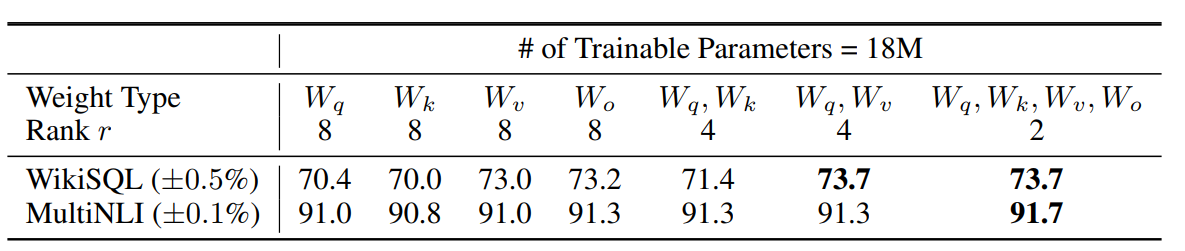

Here we set RANK to be 4 and want to change query and value matrices but you can try other ranks and matrices for your self.

<font color='#73FF73'><b>You have to complete</b></font> `mutate_model` <font color='#73FF73'><b>function.</b></font>

Replace `None` with your code.

In [12]:
def mutate_model(model: nn.Module, rank: int = RANK, alpha: float = ALPHA):
    """
    Replaces all linear layers in the model with LoRALinear layers.
    Freeze all params except LoRA params.
    """
    # make sure there are no LoRALayer is in the model; return if there are any
    for name, module in model.named_modules():
        if isinstance(module, LoRALayer):
            print("Model already contains LoRALinear layers! \n Try reloading the model.")
            return

    # we want to replace all query and value Linear modules with LoRALayer

    # iterate over the children of the model
    for name, module in model.named_children():
        # if the module is linear and the name is for query or value
        if isinstance(module, nn.Linear) and (name == 'q' or name == 'v'):
            # replace the module with LoRALayer
            ######### Your code begins #########
            lora_layer = LoRALayer(module = module , rank = rank , alpha = alpha)
            ######### Your code ends ###########
            setattr(model, name, lora_layer)
            print(f"Replaced {name} with LoRALinear layer.")
        else:
            mutate_model(module, rank, alpha) # recursively call the function on the module

mutate_model(model)

### Freeze non LoRA params

In [ ]:
def freeze_non_LoRA(model, peft_key):
    print('Non freezed weights:')
    for param_name, weights in model.named_parameters():
        weights.requires_grad = peft_key in param_name
        if weights.requires_grad:
            print(param_name)

freeze_non_LoRA(model, peft_key='sharif_llm')

Non freezed weights:
encoder.block.0.layer.0.SelfAttention.q.sharif_llm_A.weight
encoder.block.0.layer.0.SelfAttention.q.sharif_llm_B.weight
encoder.block.0.layer.0.SelfAttention.v.sharif_llm_A.weight
encoder.block.0.layer.0.SelfAttention.v.sharif_llm_B.weight
encoder.block.1.layer.0.SelfAttention.q.sharif_llm_A.weight
encoder.block.1.layer.0.SelfAttention.q.sharif_llm_B.weight
encoder.block.1.layer.0.SelfAttention.v.sharif_llm_A.weight
encoder.block.1.layer.0.SelfAttention.v.sharif_llm_B.weight
encoder.block.2.layer.0.SelfAttention.q.sharif_llm_A.weight
encoder.block.2.layer.0.SelfAttention.q.sharif_llm_B.weight
encoder.block.2.layer.0.SelfAttention.v.sharif_llm_A.weight
encoder.block.2.layer.0.SelfAttention.v.sharif_llm_B.weight
encoder.block.3.layer.0.SelfAttention.q.sharif_llm_A.weight
encoder.block.3.layer.0.SelfAttention.q.sharif_llm_B.weight
encoder.block.3.layer.0.SelfAttention.v.sharif_llm_A.weight
encoder.block.3.layer.0.SelfAttention.v.sharif_llm_B.weight
encoder.block.4.lay

# Train and evaluate

### Define dataloaders

In [9]:
col_fn = DataCollatorForSeq2Seq(
    tokenizer, return_tensors='pt', padding='longest',
)

train_loader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset['test'],
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=True
)

### Train functions

In [15]:
def train_loop(model, loader, optimizer):
    model.train()

    batch_losses = []

    for row in tqdm(loader, desc='Training:'):
        optimizer.zero_grad()

        out = model(**row.to(model.device))
        loss = out.loss

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

    loss_value = np.mean(batch_losses)
    return {'train_loss': loss_value}

def _predict(model, row):
    return model.generate(
        input_ids=row.input_ids,
        attention_mask=row.attention_mask,
        max_length=5
    )

def tokenizer_ids_to_label(all_input_ids):
    return tokenizer.batch_decode(all_input_ids, skip_special_tokens=True)

def valid_loop(model, loader, compute_metrics):
    model.eval()

    all_true = []
    all_pred = []

    with torch.no_grad():
        for row in tqdm(loader, desc='Validating:'):
            row.to(model.device)
            pred = _predict(model, row)

            all_true += row.labels.detach().cpu().tolist()
            all_pred += pred.detach().cpu().tolist()

    all_true = label2id(tokenizer_ids_to_label(all_true))
    all_pred = label2id(tokenizer_ids_to_label(all_pred))

    return {'valid_acc': compute_metrics(y_true=all_true, y_pred=all_pred)}

### Define our optimizer and metric function

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
compute_metrics = accuracy_score

In [ ]:
model.to(DEVICE)

all_results = []
for epoch in range(EPOCHS):
    epoch_results = {'epoch': epoch}

    epoch_results.update(
        train_loop(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
        )
    )

    epoch_results.update(
        valid_loop(
            model=model,
            loader=test_loader,
            compute_metrics=compute_metrics,
        )
    )
    all_results.append(epoch_results)

    display.clear_output()
    display.display(pd.DataFrame(all_results).set_index('epoch'))

,train_loss,valid_acc
epoch,,
0,2.956402,0.82284
1,0.214584,0.84944
2,0.188912,0.86080
3,0.177405,0.87020
4,0.168074,0.87452
5,0.161119,0.88004
6,0.157398,0.88168
7,0.153206,0.88500
8,0.150502,0.88408


from matplotlib import pyplot as plt
_df_0['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['valid_acc'].plot(kind='hist', bins=20, title='valid_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='train_loss', y='valid_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['valid_acc'].plot(kind='line', figsize=(8, 4), title='valid_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

### Best Performance and number of parameters

You must report this number in you final report.

In [ ]:
best_score = pd.DataFrame(all_results)['valid_acc'].max() * 100
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print('Best model preformance is: %%%.1f' % best_score)

Number of parameters: 60801536
Best model preformance is: %88.9


### Save PEFT file

We expect you to <font color='#FF7373'>upload this file </font> with the rest of your files.

In [ ]:
peft_dict = {
    key: val
    for (key, val) in model.state_dict().items()
    if 'sharif_llm' in key
}
torch.save(peft_dict, 'lora.pt')

# Use external library

Use `PEFT` library to do the same thing. [link](https://huggingface.co/docs/peft/install)

For hyperparameters, test with `RANK=1` and `RANK=8` and report them in your report.

In [10]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.0 MB/s eta 0:00:00


In [11]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [12]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_NAME)

######### Your code begins #########
####################################
####################################
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=1,
    lora_alpha=4,
    #target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 36864 || all params: 60543488 || trainable%: 0.06


In [13]:
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=LEARNING_RATE)
compute_metrics = accuracy_score

In [16]:
lora_model.to(DEVICE)

all_results = []
for epoch in range(EPOCHS):
    epoch_results = {'epoch': epoch}

    epoch_results.update(
        train_loop(
            model=lora_model,
            loader=train_loader,
            optimizer=optimizer,
        )
    )

    epoch_results.update(
        valid_loop(
            model=lora_model,
            loader=test_loader,
            compute_metrics=compute_metrics,
        )
    )
    all_results.append(epoch_results)

    display.clear_output()
    display.display(pd.DataFrame(all_results).set_index('epoch'))

,train_loss,valid_acc
epoch,,
0,2.946014,0.82088
1,0.221968,0.84580
2,0.194934,0.85660
3,0.181429,0.86644
4,0.174023,0.87120
5,0.166735,0.87684
6,0.160522,0.87716
7,0.156946,0.88292
8,0.153384,0.88484


from matplotlib import pyplot as plt
_df_0['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['valid_acc'].plot(kind='hist', bins=20, title='valid_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='train_loss', y='valid_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['valid_acc']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('valid_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('valid_acc')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['valid_acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'valid_acc'}, axis=1)
              .sort_values('valid_acc', ascending=True))
  xs = counted['valid_acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('valid_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('valid_acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['valid_acc'].plot(kind='line', figsize=(8, 4), title='valid_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

In [17]:
best_score = pd.DataFrame(all_results)['valid_acc'].max() * 100
total_params = sum(p.numel() for p in lora_model.parameters())
print(f"Number of parameters: {total_params}")
print('Best model preformance is: %%%.1f' % best_score)

Number of parameters: 60543488
Best model preformance is: %88.8


# rank = 8

In [18]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_NAME)

######### Your code begins #########
####################################
####################################
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=4,
    #target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 294912 || all params: 60801536 || trainable%: 0.49


In [19]:
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=LEARNING_RATE)
compute_metrics = accuracy_score

In [20]:
lora_model.to(DEVICE)

all_results = []
for epoch in range(EPOCHS):
    epoch_results = {'epoch': epoch}

    epoch_results.update(
        train_loop(
            model=lora_model,
            loader=train_loader,
            optimizer=optimizer,
        )
    )

    epoch_results.update(
        valid_loop(
            model=lora_model,
            loader=test_loader,
            compute_metrics=compute_metrics,
        )
    )
    all_results.append(epoch_results)

    display.clear_output()
    display.display(pd.DataFrame(all_results).set_index('epoch'))

,train_loss,valid_acc
epoch,,
0,3.067798,0.81868
1,0.220113,0.84580
2,0.192639,0.85976
3,0.177578,0.86764
4,0.171305,0.87308
5,0.164354,0.87760
6,0.159265,0.88020
7,0.154770,0.88468
8,0.151808,0.88656


from matplotlib import pyplot as plt
_df_7['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['valid_acc'].plot(kind='hist', bins=20, title='valid_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='train_loss', y='valid_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['valid_acc']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('valid_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('valid_acc')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['valid_acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'valid_acc'}, axis=1)
              .sort_values('valid_acc', ascending=True))
  xs = counted['valid_acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('valid_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('valid_acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['valid_acc'].plot(kind='line', figsize=(8, 4), title='valid_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

In [21]:
best_score = pd.DataFrame(all_results)['valid_acc'].max() * 100
total_params = sum(p.numel() for p in lora_model.parameters())
print(f"Number of parameters: {total_params}")
print('Best model preformance is: %%%.1f' % best_score)

Number of parameters: 60801536
Best model preformance is: %88.7
